In [ ]:
%pip install opencv-python tensorflow keras Pillow

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 428ms/step - accuracy: 0.1496 - loss: 2.1714 - val_accuracy: 0.2639 - val_loss: 2.0465
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.2788 - loss: 1.9846 - val_accuracy: 0.3194 - val_loss: 1.9678
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2999 - loss: 1.9707 - val_accuracy: 0.3333 - val_loss: 1.8351
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3078 - loss: 1.8902 - val_accuracy: 0.3611 - val_loss: 1.8269
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3427 - loss: 1.7791 - val_accuracy: 0.3611 - val_loss: 1.8460
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3719 - loss: 1.8225 - val_accuracy: 0.4306 - val_loss: 1.7046
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3491 - loss: 1.7035 - val_accuracy: 0.4306 - val_loss: 1.7103
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3749 - loss: 1.6800 - val_accuracy: 0.5139 - val_loss: 

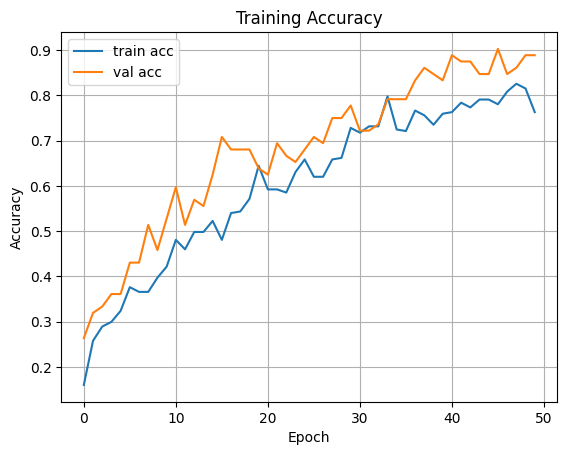

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# ---- Step 1: Load and preprocess dataset ----
data_dir = "/content/drive/MyDrive/ projects/dataset"
labels = sorted(os.listdir(data_dir))  # Sorted for consistent label mapping

X, y = [], []

for idx, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)
    for file in os.listdir(label_dir):
        path = os.path.join(label_dir, file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        X.append(img)
        y.append(idx)

X = np.array(X).astype("float32") / 255.0
X = np.expand_dims(X, axis=-1)  # (128,128,1)
y = to_categorical(y, num_classes=len(labels))

# ---- Step 2: Train-Test Split ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Step 3: Data Augmentation ----
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1
    # horizontal_flip removed to avoid confusion for directional classes
)
datagen.fit(X_train)

# ---- Step 4: Build CNN Model ----
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),  # Extra layer for better learning
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ---- Step 5: Callbacks ----
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("bestemo.keras", monitor='val_accuracy', save_best_only=True)

# ---- Step 6: Train Model ----
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stop, checkpoint]
)

# ---- Step 7: Visualize Training ----
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()




In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import os

# Load the saved model
model_path = "/content/drive/MyDrive/projects/bestemo.keras"
model = tf.keras.models.load_model(model_path)

# Define labels
data_dir = "/content/drive/MyDrive/projects/dataset"
labels = sorted(os.listdir(data_dir))  # Sorted for consistent label mapping


# ---- Step 8: Test with a sample image ----
test_img_path = "/content/drive/MyDrive/ projects/dataset/sun/20250613_233053.png"
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (128, 128))
test_img = test_img.astype("float32") / 255.0
test_img = np.expand_dims(test_img, axis=-1)
test_img = np.expand_dims(test_img, axis=0)  # Shape = (1, 128, 128, 1)

prediction = model.predict(test_img)
predicted_label = labels[np.argmax(prediction)]
confidence = np.max(prediction)

print(f"\n✅ Predicted Label: {predicted_label} (Confidence: {confidence*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step

✅ Predicted Label: sun (Confidence: 60.82%)
